In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from lightgbm import LGBMRegressor
import lightgbm
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
import plotly.express as px

In [2]:
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [209]:
prev_lgbm_train_mse = np.inf
prev_lgbm_val_mse = np.inf
prev_lgbm_train_acc = 0
prev_lgbm_val_acc = 0

prev_linear_train_mse = np.inf
prev_linear_val_mse = np.inf
prev_linear_train_acc = 0
prev_linear_val_acc = 0
# Function to print colored comparison
def hprint(current, previous, better_is_lower=True):
    if current == previous:
        color_code = "\033[0m"  # Default color for no change
    elif (better_is_lower and current < previous) or (not better_is_lower and current > previous):
        color_code = "\033[92m"  # Green for improvement
    else:
        color_code = "\033[91m"  # Red for worse
    reset_code = "\033[0m"
    print(f"{color_code}{current:.8f} (Prev: {previous:.8f}){reset_code}")

In [17]:
def rolling_linear_regression(X, y, window_size):
    X_roll_sum = X.rolling(window=window_size, min_periods=1).sum()
    y_roll_sum = y.rolling(window=window_size, min_periods=1).sum()
    X2_roll_sum = (X ** 2).rolling(window=window_size, min_periods=1).sum()
    Xy_roll_sum = (X * y).rolling(window=window_size, min_periods=1).sum()

    # Compute beta (slope of regression line) for each window
    beta = (Xy_roll_sum - (X_roll_sum * y_roll_sum) / window_size) / (X2_roll_sum - (X_roll_sum ** 2) / window_size)
    
    # # Fill NaNs in beta with 0 to avoid issues at the beginning
    # beta = beta.fillna(0)

    return beta

In [380]:
train_date = pd.to_datetime("05/01/24")
val_date = pd.to_datetime("08/01/24")
test_date = pd.to_datetime("09/01/24")

window_size = 2016 #One week of indexes

btc_df = pd.read_parquet("data/BTCUSDT.pq")
btc_df = btc_df.sort_values(by = "time")
btc_df["return"] = btc_df["close"] - btc_df["close"].shift(1)
# btc_df["return"] = np.log(btc_df['close']/btc_df['close'].shift(1))
btc_df = btc_df.drop(btc_df.index[0])
btc_df.reset_index(inplace=True)


if not os.path.exists("market_neutral/"):
    os.mkdir("market_neutral/")

for filename in os.listdir("data/"):
    if filename.endswith(".pq") and filename != "BTCUSDT.pq":
        x_df = pd.read_parquet(os.path.join("data/", filename))
        x_df = x_df.sort_values(by = "time")
        x_df["return"] = x_df["close"] - x_df["close"].shift(1)
        x_df = x_df.dropna()

        if (x_df.shape[0] != btc_df.shape[0]) or (not all(btc_df.time.values == x_df.time.values)):
            # print(f"Times dont add up for file {filename}")
            continue
        
        X = btc_df["return"]
        y = x_df["return"]

        beta = rolling_linear_regression(X, y, window_size)

        # X = btc_df["return"].values.reshape(-1, 1)
        # y = x_df["return"].values

        # model = LinearRegression().fit(X, y)
        # beta = model.coef_[0]

        MN_x = x_df.copy()
        columns = ["return"]
        MN_x["return"] = x_df["return"] - beta * btc_df["return"]
        MN_x["mn_close"] = x_df["close"] - beta * btc_df["close"]
        MN_x["mn_open"] = x_df["open"] - beta * btc_df["open"]
        MN_x["mn_high"] = x_df["high"] - beta * btc_df["high"]
        MN_x["mn_low"] = x_df["low"] - beta * btc_df["low"]
        MN_x = MN_x.loc[:,["time", "close", "mn_close", "mn_open", "mn_high", "mn_low", "return", "volume", "turnover"]] #makes above line a little reundant
        MN_x.reset_index(drop=True, inplace=True)
        
        MN_x.to_parquet(f"market_neutral/MN_{filename[:-3]}.pq")

In [285]:
print(MN_x.head())

                 time    close  mn_close   mn_open   mn_high    mn_low  \
0 2024-04-01 00:05:00  0.03694  0.034642  0.034453  0.034641  0.034285   
1 2024-04-01 00:10:00  0.03684  0.034565  0.034665  0.035014  0.034376   
2 2024-04-01 00:15:00  0.03670  0.034419  0.034558  0.034778  0.034360   
3 2024-04-01 00:20:00  0.03664  0.034392  0.034451  0.034631  0.034363   
4 2024-04-01 00:25:00  0.03655  0.034327  0.034419  0.034446  0.034239   

     return     volume      turnover  
0  0.000189  2205117.0   81100.93401  
1 -0.000100  7212700.0  266399.14396  
2 -0.000139  2959827.0  109232.56982  
3 -0.000060  1262221.0   46338.97897  
4 -0.000092  2534471.0   92639.28613  


In [384]:
mn_silly = pd.read_parquet("market_neutral/MN_SILLYUSDT.pq")
mn_silly.set_index("time", inplace=True)

mn_silly["y"] = (mn_silly["mn_close"].shift(-24)-mn_silly["mn_close"])/np.abs(mn_silly["mn_close"])
mn_silly["ema10"] = mn_silly["mn_close"] - mn_silly["mn_close"].ewm(span=10).mean()
mn_silly["ema100"] = mn_silly["mn_close"] - mn_silly["mn_close"].ewm(span=100).mean()
mn_silly["ema1000"] = mn_silly["mn_close"] - mn_silly["mn_close"].ewm(span=1000).mean()
mn_silly["ema10000"] = mn_silly["mn_close"] - mn_silly["mn_close"].ewm(span=1000).mean()
mn_silly["30m_lag"] = mn_silly["mn_close"] - mn_silly["mn_close"].shift(6)
mn_silly["1h_lag"] = mn_silly["mn_close"] - mn_silly["mn_close"].shift(12)
mn_silly["2h_lag"] = mn_silly["mn_close"] - mn_silly["mn_close"].shift(24)
mn_silly["3h_lag"] = mn_silly["mn_close"] - mn_silly["mn_close"].shift(36)

delta = mn_silly["return"]
gain = (delta.where(delta > 0, 0)).rolling(window=500).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=500).mean()
rs = gain / loss
mn_silly['rsi'] = 100 - (100 / (1 + rs))

mn_silly['prev_close'] = mn_silly['mn_close'].shift(1)
mn_silly["true_range"] = np.maximum(
    mn_silly['mn_high'] - mn_silly['mn_low'], 
    np.maximum(abs(mn_silly['mn_high'] - mn_silly['prev_close']), abs(mn_silly['mn_low'] - mn_silly['prev_close']))
)
mn_silly["atr"] = mn_silly["true_range"].rolling(window=20).mean()

mn_silly.drop(columns=["turnover", "close", "mn_close", "true_range", "prev_close", "mn_open", "mn_high", "mn_low", "return"], inplace=True)
mn_silly = mn_silly.dropna()
# print(mn_silly.head())
# plt.figure()
# plt.plot(mn_silly["rsi"])
# mn_silly[mn_silly.index > train_date].head(25)

In [388]:
X = mn_silly

X_train = X[(X.index > train_date) & (X.index < val_date)]
y_train = X_train["y"]
X_train = X_train.drop(columns=["y"])

X_val = X[(X.index >= val_date) & (X.index < test_date)]
y_val = X_val["y"]
X_val = X_val.drop(columns=["y"])

X_test = X[X.index > test_date]
y_test = X_test["y"]
X_test = X_test.drop(columns=["y"])

params = {}
params = {'subsample': 0.8, 'num_leaves': 6, 'n_estimators': 15, 'min_child_samples': 40, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
params.update({"verbose": -1})
lgbm_model = LGBMRegressor(**params)
lgbm_model.fit(X_train, y_train)

y_pred_train = lgbm_model.predict(X_train)
y_pred_val = lgbm_model.predict(X_val)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_train_linear = linear_model.predict(X_train)
y_pred_val_linear = linear_model.predict(X_val)

lgbm_train_mse = mean_squared_error(y_pred_train, y_train)
lgbm_val_mse = mean_squared_error(y_pred_val, y_val)
lgbm_train_acc = np.sum(np.sign(y_train) == np.sign(y_pred_train)) / y_train.shape[0]
lgbm_val_acc = np.sum(np.sign(y_val) == np.sign(y_pred_val)) / y_val.shape[0]

# Linear Model training and evaluation
linear_train_mse = mean_squared_error(y_pred_train_linear, y_train)
linear_val_mse = mean_squared_error(y_pred_val_linear, y_val)
linear_train_acc = np.sum(np.sign(y_train) == np.sign(y_pred_train_linear)) / y_train.shape[0]
linear_val_acc = np.sum(np.sign(y_val) == np.sign(y_pred_val_linear)) / y_val.shape[0]

# Print LGBM Results
print("LGBM Train MSE: ", end="")
hprint(lgbm_train_mse, prev_lgbm_train_mse)
print("LGBM Val MSE: ", end="")
hprint(lgbm_val_mse, prev_lgbm_val_mse)
print("LGBM Train Accuracy: ", end="")
hprint(lgbm_train_acc, prev_lgbm_train_acc, better_is_lower=False)
print("LGBM Val Accuracy: ", end="")
hprint(lgbm_val_acc, prev_lgbm_val_acc, better_is_lower=False)

# Print Linear Results
print("Linear Train MSE: ", end="")
hprint(linear_train_mse, prev_linear_train_mse)
print("Linear Val MSE: ", end="")
hprint(linear_val_mse, prev_linear_val_mse)
print("Linear Train Accuracy: ", end="")
hprint(linear_train_acc, prev_linear_train_acc, better_is_lower=False)
print("Linear Val Accuracy: ", end="")
hprint(linear_val_acc, prev_linear_val_acc, better_is_lower=False)

# Naive Accuracy
naive_accuracy = max((y_val > 0).mean(), (y_val <= 0).mean())
print(f"Naive Val Accuracy: {naive_accuracy:.4f}")

prev_lgbm_train_mse = lgbm_train_mse
prev_lgbm_val_mse = lgbm_val_mse
prev_lgbm_train_acc = lgbm_train_acc
prev_lgbm_val_acc = lgbm_val_acc

prev_linear_train_mse = linear_train_mse
prev_linear_val_mse = linear_val_mse
prev_linear_train_acc = linear_train_acc
prev_linear_val_acc = linear_val_acc

LGBM Train MSE: 0.00050629 (Prev: 0.00051284)
LGBM Val MSE: 0.00088563 (Prev: 0.00088629)
LGBM Train Accuracy: 0.53764861 (Prev: 0.53172297)
LGBM Val Accuracy: 0.50436828 (Prev: 0.50828853)
Linear Train MSE: 0.00052110 (Prev: 0.00052110)
Linear Val MSE: 0.00089345 (Prev: 0.00089345)
Linear Train Accuracy: 0.52670315 (Prev: 0.52670315)
Linear Val Accuracy: 0.50694444 (Prev: 0.50694444)
Naive Val Accuracy: 0.5086


In [387]:
# Combine X_train and X_val into one dataset
X_combined = np.vstack([X_train, X_val])
y_combined = np.hstack([y_train, y_val])

# Create PredefinedSplit (validation indices are indicated with -1 for training and 0 for validation)
train_indices = [-1] * len(X_train)  # Training data
val_indices = [0] * len(X_val)       # Validation data
test_fold = np.array(train_indices + val_indices)
ps = PredefinedSplit(test_fold)

param_grid = {
    'n_estimators': [8, 12, 15, 16, 17],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [5, 6, 7],
    'max_depth': [-1, 10, 20, 30],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgbm = LGBMRegressor(**{"verbose": -1})

random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_grid,
                                   n_iter=100, scoring='neg_mean_squared_error', cv=ps, verbose=2, n_jobs=-1, random_state=42)

random_search.fit(X_combined, y_combined)

print(f'Best parameters: {random_search.best_params_}')
print(f'Best score: {-random_search.best_score_}')

Fitting 1 folds for each of 100 candidates, totalling 100 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, min_child_samples=30, n_estimators=8, num_leaves=6, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=20, min_child_samples=40, n_estimators=16, num_leaves=5, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=20, min_child_samples=20, n_estimators=12, num_leaves=7, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, min_child_samples=40, n_estimators=15, num_leaves=6, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=30, min_child_samples=30, n_estimators=17, num_leaves=6, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=-1, min_child_samples=20, n_estimators=15, num_leaves=7, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=

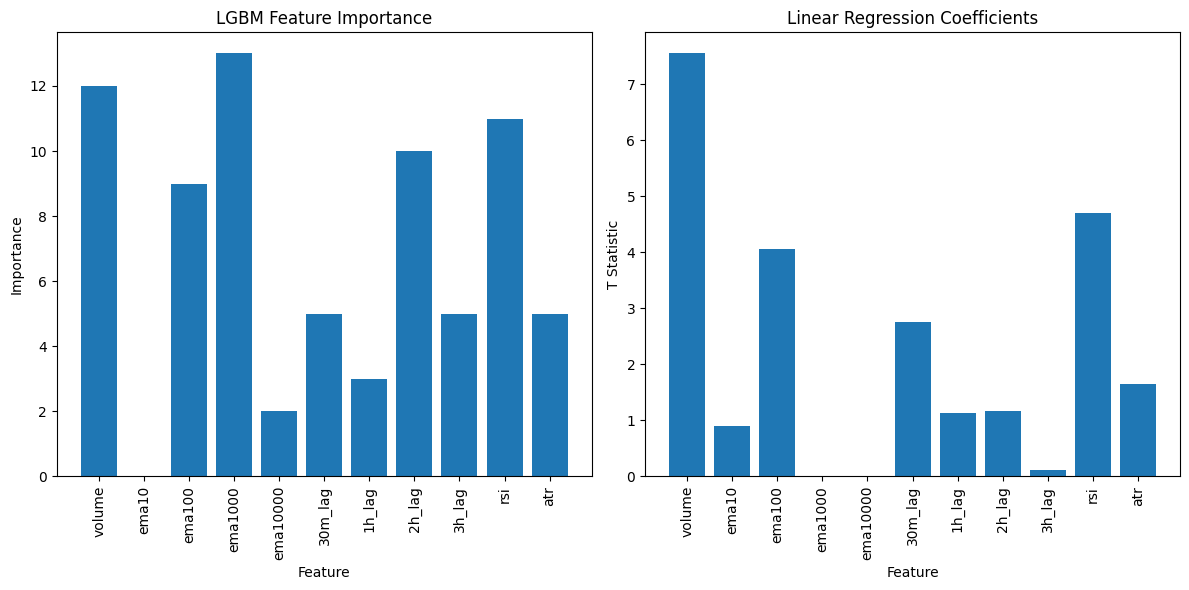

In [392]:
feature_names = X_train.columns  # Assuming X_train is a DataFrame. If not, provide a list of names manually.

# Create a figure with two subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# LGBM Feature Importance
ax[0].bar(feature_names, lgbm_model.feature_importances_)
ax[0].set_title("LGBM Feature Importance")
ax[0].set_xlabel("Feature")
ax[0].set_ylabel("Importance")
ax[0].tick_params(axis='x', rotation=90)  # Rotate x labels for better readability

residuals = y_pred_train - y_train
n = len(y_train)  # number of observations
p = X_train.shape[1]  # number of features
# Standard error of the residual
residual_std_error = np.sqrt(np.sum(residuals**2) / (n - p - 1))

# Variance-covariance matrix of the coefficients
X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]  # Add intercept term
cov_matrix = np.linalg.inv(X_train_with_intercept.T.dot(X_train_with_intercept))
standard_errors = np.sqrt(np.diag(cov_matrix)) * residual_std_error

# Calculate t-statistics
t_stats = linear_model.coef_ / standard_errors[1:]
# Linear Regression Feature Importance (Absolute value of coefficients)
ax[1].bar(feature_names, np.abs(t_stats))
ax[1].set_title("Linear Regression Coefficients")
ax[1].set_xlabel("Feature")
ax[1].set_ylabel("T Statistic Magnitude")
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [376]:
mn_silly = pd.read_parquet("market_neutral/MN_SILLYUSDT.pq")
mn_silly.set_index(mn_silly.time, inplace=True)
mn_silly = mn_silly.sort_index()


prediction = pd.DataFrame(index = X_val.index)
prediction["pred"] = y_pred_val
prediction["pred_linear"] = y_pred_val_linear
mn_silly[["pred", "pred_linear"]] = prediction
mn_silly = mn_silly[(mn_silly.time >= val_date) & (mn_silly.time < test_date)]

# margin = 0.0011 + 2*0.00055
margin = 0.000
bp = 0.01/100
mn_silly["next_change"] = mn_silly["mn_close"].shift(-12) - mn_silly["mn_close"]
mn_silly["change"] = np.where(np.abs(mn_silly["pred"]) > (margin - 0 * bp), np.where(mn_silly["pred"] > 0, mn_silly["next_change"], -mn_silly["next_change"]) - margin * mn_silly["close"], 0)
mn_silly["pl"] = mn_silly["change"].cumsum()

mn_silly["change_linear"] = np.where(np.abs(mn_silly["pred_linear"]) > (margin + 0 * bp), np.where(mn_silly["pred_linear"] > 0, mn_silly["next_change"], -mn_silly["next_change"]) - margin * mn_silly["close"], 0)
mn_silly["pl_linear"] = mn_silly["change_linear"].cumsum()

print(mean := np.mean(mn_silly["change"][mn_silly["change"]!=0]))
print(std := np.std(mn_silly["change"][mn_silly["change"]!=0]))
print(sharpe := mean/std)
print(mn_silly["pl"][mn_silly.index<test_date].iloc[-13])

5.549238604302265e-06
0.0002719624005554089
0.020404433086961514
0.04947701139595927


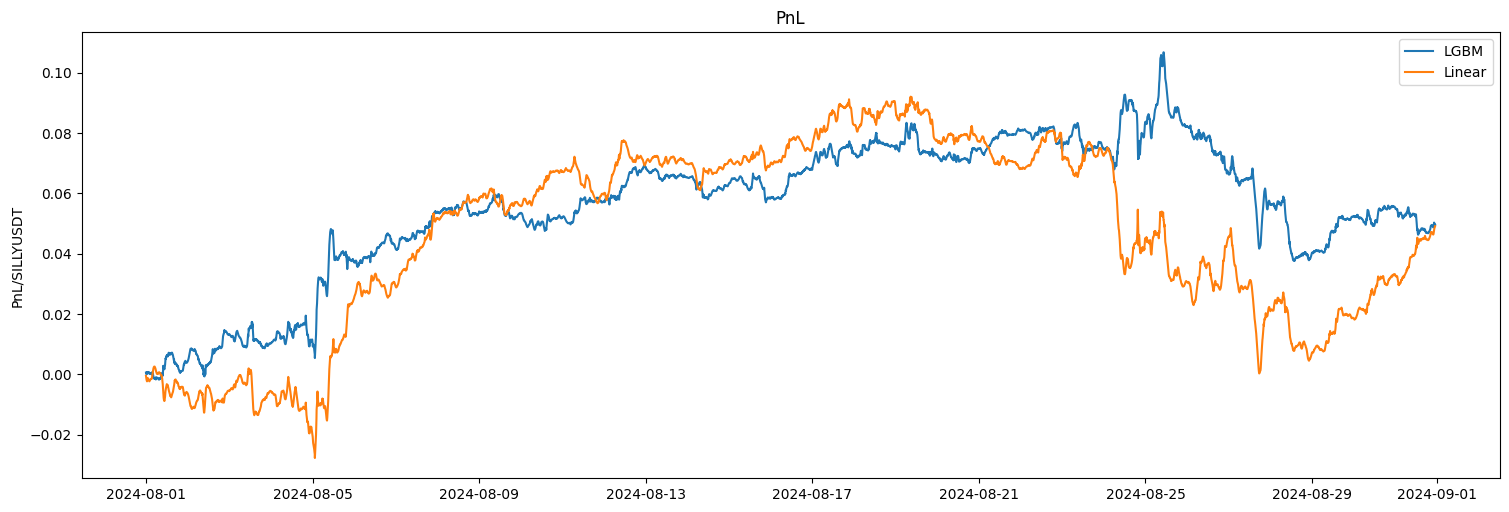

In [377]:
plt.figure(figsize=(15,5))
plt.plot(mn_silly["pl"])
plt.plot(mn_silly["pl_linear"])
plt.tight_layout()
plt.ylabel("PnL/SILLYUSDT")
plt.title("PnL")
plt.legend(["LGBM", "Linear"])
plt.show()

Text(0.5, 1.0, 'MN_SILLY Close')

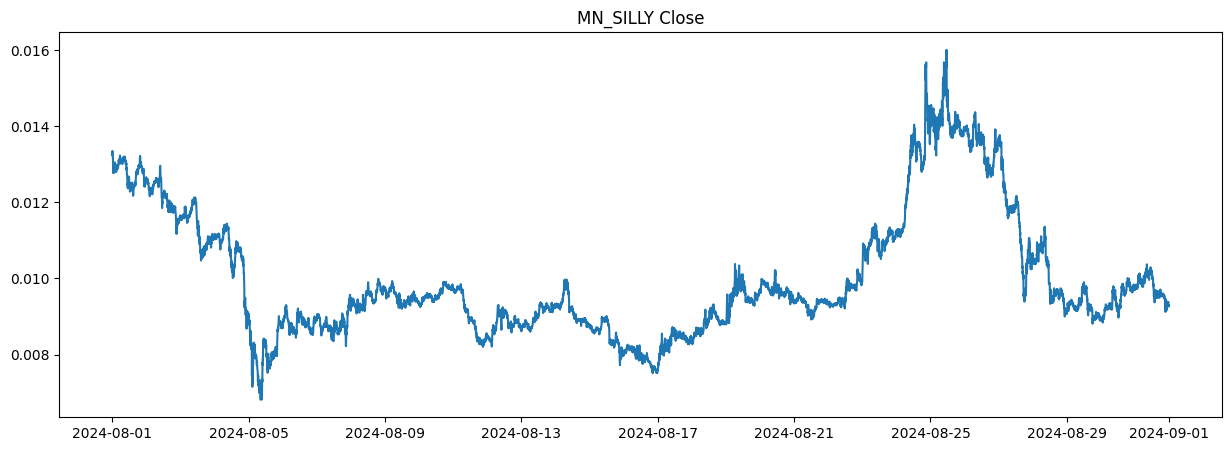

In [378]:
plt.figure(figsize=(15,5))
plt.plot(mn_silly["close"])
plt.title("MN_SILLY Close")

In [ ]:
def generate_features(df):
    # Ensure the dataframe is sorted by time
    
    # The mn_return column already contains 1-hour returns
    df['log_return'] = np.log(df['mn_close']/df["mn_close"].shift(1))  # Adding 1 to handle negative returns
    print("done")
    # Custom moving averages and related features
    for window in [5, 10, 20, 50, 100]:
        df[f'sma_{window}h'] = df['mn_close'].rolling(window=window*60).mean()
        df[f'ema_{window}h'] = df['mn_close'].ewm(span=window*60, adjust=False).mean()
        df[f'return_ma_{window}h'] = df['log_return'].rolling(window=window*60).mean()
        df[f'return_std_{window}h'] = df['log_return'].rolling(window=window*60).std()
        df[f'z_score_{window}h'] = (df['mn_close'] - df[f'sma_{window}h']) / df['mn_close'].rolling(window=window*60).std()
    print("done")
    # Price momentum
    for lag in [1, 5, 10, 20]:
        df[f'momentum_{lag}h'] = df['mn_close'].pct_change(lag*60)
    print("done")
    # Return autocorrelation

    @numba.jit(nopython=True)
    def autocorr(x, lag):
        return np.correlate(x[lag:] - x[lag:].mean(), x[:-lag] - x[:-lag].mean())[0] / (np.std(x[lag:]) * np.std(x[:-lag]) * len(x[lag:]))

    def rolling_autocorr(series, window, lag):
        return series.rolling(window=window).apply(lambda x: autocorr(x, lag), raw=True, engine='numba')

    # In your generate_features function:
    for lag in [1, 5, 10, 20]:
        df[f'return_autocorr_{lag}h'] = rolling_autocorr(df['log_return'], lag*120, lag*60)
    print("done")
    # Volatility measures
    df['volatility_4h'] = df['log_return'].rolling(window=240).std()
    df['volatility_1d'] = df['log_return'].rolling(window=1440).std()
    df['volatility_1w'] = df['log_return'].rolling(window=10080).std()
    print("done")
    # Range-based features
    df['daily_range'] = df['mn_close'].rolling(window=1440).max() - df['mn_close'].rolling(window=1440).min()
    df['price_range_percentile'] = (df['mn_close'] - df['mn_close'].rolling(window=1440).min()) / df['daily_range']
    print("done")
    # RSI
    df['rsi'] = ta.momentum.RSIIndicator(df['mn_close'], window=1440).rsi()
    print("done")
    # MACD
    macd = ta.trend.MACD(df['mn_close'], window_slow=26*60, window_fast=12*60, window_sign=9*60)
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = macd.macd_diff()
    print("done")
    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(df['mn_close'], window=20*60)
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    df['bb_pct'] = (df['mn_close'] - df['bb_low']) / (df['bb_high'] - df['bb_low'])
    print("done")
    # Transformed features
    df['rank_price'] = df['mn_close'].rank(pct=True)
    df['ts_rank_price_1d'] = df['mn_close'].rolling(window=1440).apply(lambda x: stats.percentileofscore(x, x.iloc[-1]))
    df['price_change_rate'] = df['mn_close'].pct_change(60)  # 1-hour change rate
    print("done")
    # Volume-based features
    df['volume_ma_1d'] = df['volume'].rolling(window=1440).mean()
    df['volume_ma_1w'] = df['volume'].rolling(window=10080).mean()
    df['relative_volume'] = df['volume'] / df['volume_ma_1d']
    print("done")
    # Turnover-based features
    df['turnover_ma_1d'] = df['turnover'].rolling(window=1440).mean()
    df['turnover_ma_1w'] = df['turnover'].rolling(window=10080).mean()
    df['relative_turnover'] = df['turnover'] / df['turnover_ma_1d']
    print("done")
    # Fourier transforms for cyclical patterns
    # def fourier_transform(x, num_components=3):
    #     if len(x) == 0:
    #         return np.nan
    #     f = fft(x)
    #     f_abs = np.abs(f)
    #     indices = np.argsort(f_abs)[::-1][:num_components]
    #     return np.sum(f_abs[indices])  # Return the sum of the magnitudes of the top components

    # # In your generate_features function:
    # df['fourier_7d'] = df['mn_close'].rolling(window=10080).apply(fourier_transform, raw=True)
    # print("done")
    # # Fractal dimension
    # def hurst_exponent(x):
    #     lags = range(2 * 60, 100 * 60, 60)
    #     tau = [np.sqrt(np.std(np.subtract(x[lag:], x[:-lag]))) for lag in lags]
    #     poly = np.polyfit(np.log(lags), np.log(tau), 1)
    #     return poly[0] * 2.0
    
    # df['hurst_exponent'] = df['mn_close'].rolling(window=1440).apply(hurst_exponent)
    
    # Cross-sectional neutralization (assuming you have multiple assets)
    # This would typically be done across assets, but as an example:
    # df['cs_neutral_price'] = df['mn_close'] - df['mn_close'].rolling(window=1440).mean()
    df = df.dropna()
    return df